<a href="https://www.kaggle.com/code/gregemmen/binary-classification-for-bank-churn-ge-notebook?scriptVersionId=159257590" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Playground Series S4E1 - Bank Churn Classification

## Step 1 - Understand the Problem

The goal of this project is to predict whether a bank customer will continue or close their account (e.g. churns) based on a client's individual characteristics.

### Evaluation Metric
Submissions will be evaluated on area under the ROC curve (AUC) between the predicted probability and the observed target.

### Dataset Description
The training dataset for this model is synthetic, and was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Since more data is always helpful, it's possible to use the original dataset in model development (though the original data might require additional processing).

- **train.csv** is the training dataset; 'Exited' is the binary target.
- **test.csv** is the test dataset; with the objective of predicting the probabilitiy of 'Exited'.
- **submission.csv** is the final deliverable for the competition.

### Import and Config

- Import the libraries we will use for analysis.
- Set the basic theme.
- Load the provided datasets.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import sklearn as sk # machine learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve, auc, accuracy_score

from sklearn import preprocessing

# use seaborn to set a general theme for visualizations
sns.set_theme(style="whitegrid", palette="bright") 
sns.set(font_scale=0.7)

# use pandas to load the train/test datasets
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

## Step 2.1 - Initial Look at Data

In this phase of the analysis we are interested in visualizing the datasets. The goal is to understand correlations and identify any helpful insights that might prove usefull when we move into the next steps.

In [2]:
# check out the training dataset
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


From the training dataset, we have the following categories to work with:

- ID
- Customer ID
- Surname
- Credit Score
- Geography
- Gender
- Age
- Tenure
- Balance
- Nubmer of Products
- Has Credit Card
- Is Active Member
- Estimated Salary
- Exited

Of these categories we can see a few things straight away. The **ID**, **Customer ID**, and **Surname** categories are probably not going to be useful. These categories are useful as identifiers, but will end up as redundant identifiers that are not as good as the **ID** data alone.

Additionally, we can see that the **Geography** and **Gender** categories are saved as strings. We will want to encode this data later on.

In [3]:
# check out the training dataset info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


Here we can see that there are 165034 entries in this dataset. Plenty to work with!

In [4]:
# check if there are any null values in the training dataset
df_train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
# check if there are any duplicate values in the training dataset
df_train.duplicated().sum()

0

Thankfully the training data is pre-processed and has no null values or duplicates. This should help speed up any work in the data processing stage. Later on we may explore the addition of the original data (which is known to have some duplicates and null values) in order to see if it will help with our model.

Let's repeat the steps from above with our test dataset

In [6]:
# check out the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


In [7]:
# check if there are any null values in the training dataset
df_test.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [8]:
# check if there are any duplicate values in the training dataset
df_test.duplicated().sum()

0

The test dataset looks just as good as the training dataset. With that background, we can start moving into some of our visualization to understand what the data actually means.

## Step 2.2 - Dataset Visualization

Let's start by plotting some of the data. We will use seaborn and matplotlib to make the visualizations look nice. We will be focusing the visualization phase on the training data - so that we can see the interaction with the key **Exited** value. Since I'm approaching this project as a learning experience, I've opted to try several different methods for plotting and visualizing different data together.

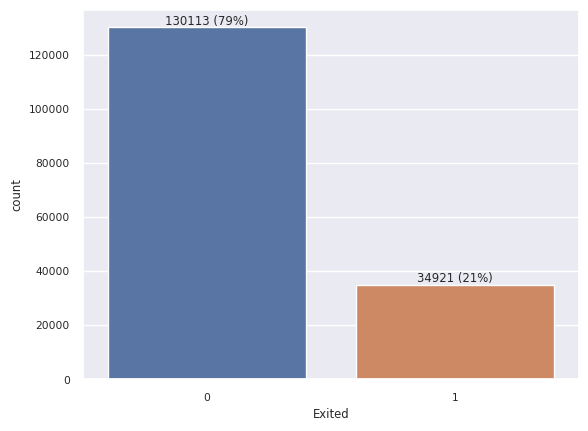

In [9]:
# build a count plot of all 'exited' values, showing the percentages tied to each category

ax = sns.countplot(x=df_train['Exited']); # specify the data we want to visualize
        
abs_values = df_train['Exited'].value_counts(ascending=False) # calculate the absolute values
rel_values = df_train['Exited'].value_counts(ascending=False, normalize=True).values * 100 # calculate the relative values (percentages)
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)] # generate labels to add to the bars in our chart

ax.bar_label(container=ax.containers[0], labels=lbls) # put it all together
plt.figsize=(10,10) # specify the figure size we want
plt.show() # show the plot

Here we can see that our training dataset has a significant difference between customers who have not exited (79%) and customers who have exited (21%). This might come into play later.

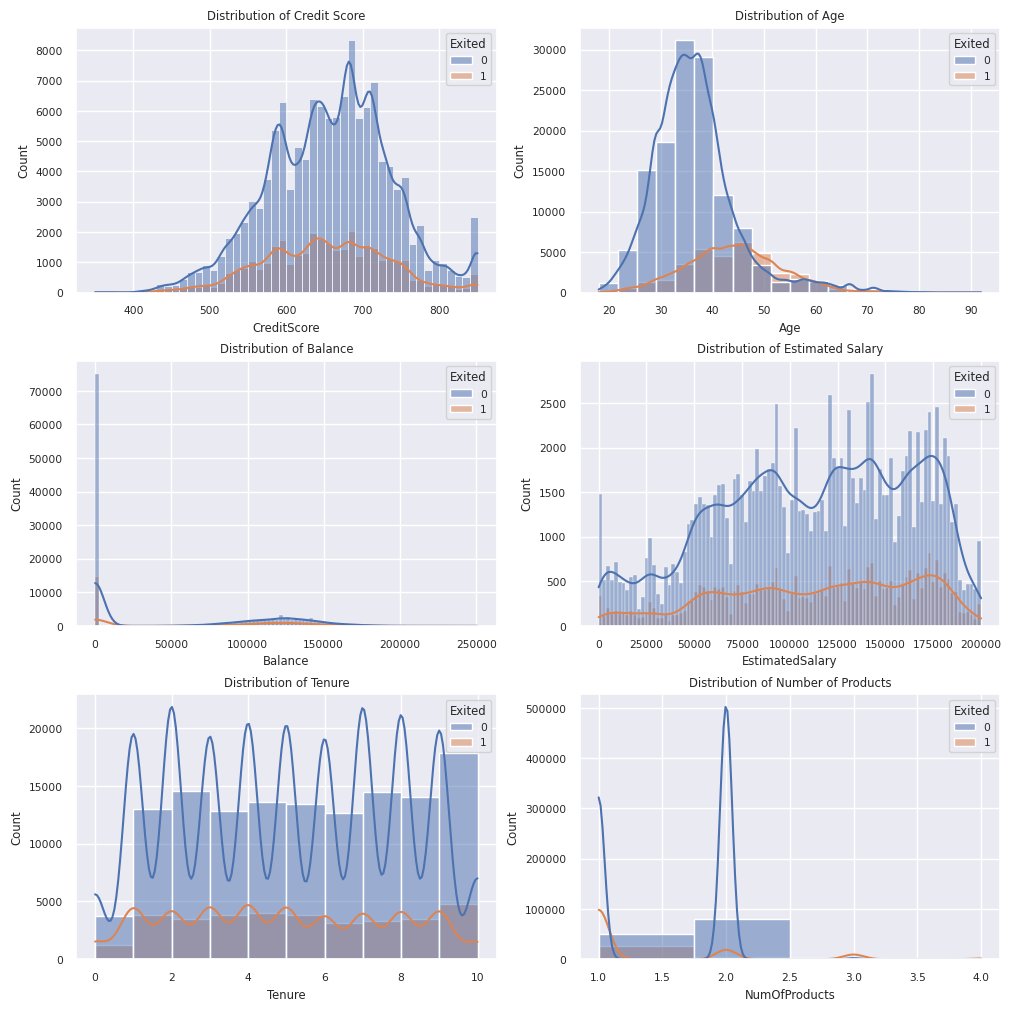

In [10]:
# build some histograms to see how different values are tied to whether or not a customer exits

fig, axes = plt.subplots(3,2,figsize=(10,10), constrained_layout=True) # specify the subplot layout and sizes

# first plot - credit score separated by customers that have exited
plt.subplot(3, 2, 1)
sns.histplot(data=df_train, x="CreditScore", hue="Exited", bins=50, kde=True)
plt.title("Distribution of Credit Score")

# second plot - age separated by customers that have exited
plt.subplot(3, 2, 2)
sns.histplot(data=df_train, x="Age", hue="Exited", bins=20, kde=True)
plt.title("Distribution of Age")

# third plot - bank acount balance values separated by customers that have exited
plt.subplot(3, 2, 3)
sns.histplot(data=df_train, x="Balance", hue="Exited", bins=100, kde=True)
plt.title("Distribution of Balance")

# fourth plot - estimated salary separated by customers that have exited
plt.subplot(3, 2, 4)
sns.histplot(data=df_train, x="EstimatedSalary", hue="Exited", bins=100, kde=True)
plt.title("Distribution of Estimated Salary")

# fifth plot - tenure separated by customers that have exited
plt.subplot(3, 2, 5)
sns.histplot(data=df_train, x="Tenure", hue="Exited", bins=10, kde=True)
plt.title("Distribution of Tenure")

# sixth plot - number of products separated by customers that have exited
plt.subplot(3, 2, 6)
sns.histplot(data=df_train, x="NumOfProducts", hue="Exited", bins=4, kde=True)
plt.title("Distribution of Number of Products")

fig.show() # show the plot

These plots show some interesting insights. Credit score seems to be a poor predictor of whether or not a customer will exit, which runs counter to my original thoughts. Tenure doesn't seem to have any correlation at all. Age seems to be the best predictor of whether or not someone will exit - with more people leaving at higher ages. Account balance and number of products might have correlations, but we can't really tell right now.

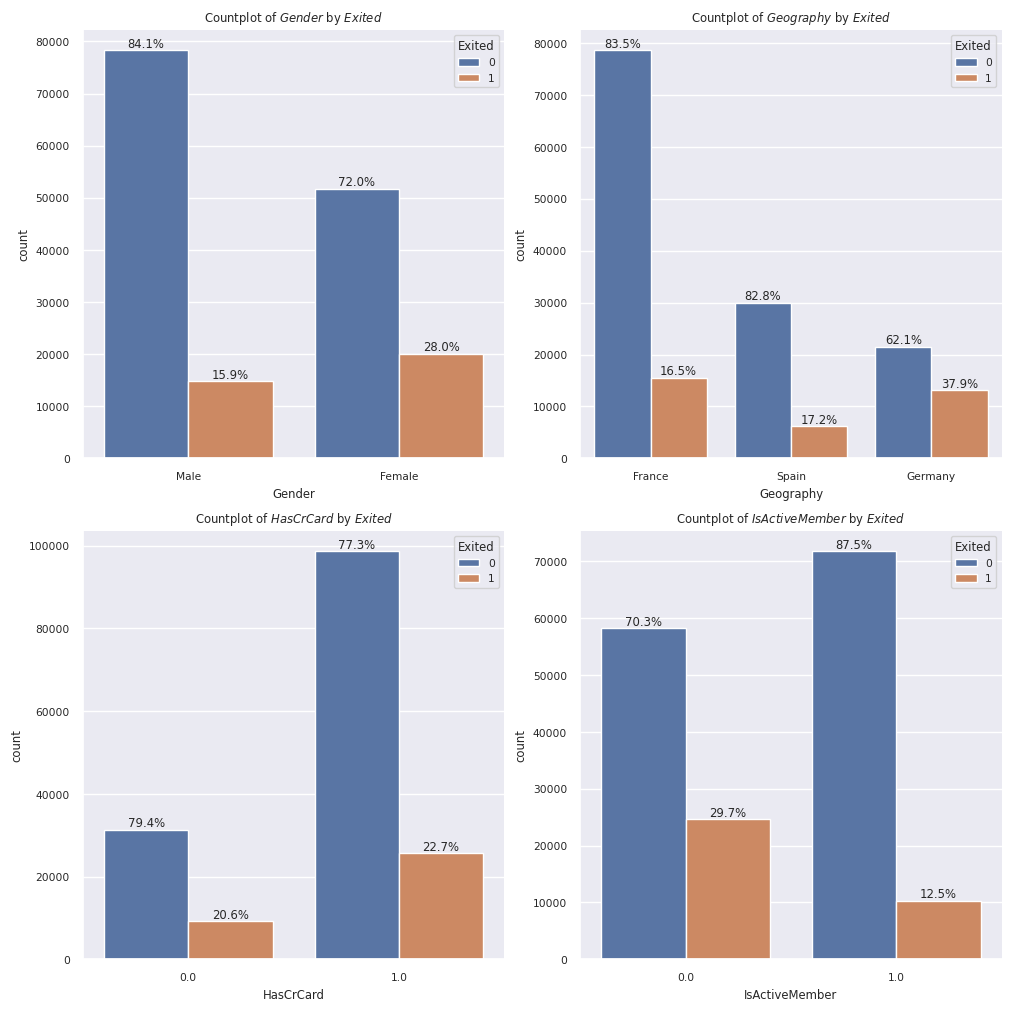

In [11]:
# different method for creating a count plot that includes percentage values of exited vs not-exited

features = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember'] # specify the features we want to analyze
hue = 'Exited' # set the variable we want to separate the categories on
hue_type = df_train[hue].dtype.type

fig, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True) # define the figure sizes and layout

# run through each feature specififed
for feat, ax in zip(features, axs.ravel()):
    col = df_train[feat]
    
    # determine how to group the feature for the plot
    if col.dtype == 'category':
        groups = col.cat.categories
    elif col.dtype == 'bool':
        groups = [False, True]
    else:
        groups = col.unique()
        
    proportions = df_train.groupby(feat)[hue].value_counts(normalize=True) # group the features by the 'exit' variable
    
    # specify some features of the count plots
    sns.countplot(x=feat, hue=hue, data=df_train, ax=ax)
    ax.set_title(f'Countplot of ${feat}$ by ${hue}$')
    sns.despine()
    
    # step through each of the groups (determined above) and label the bars appropriately
    for c in ax.containers:
        labels = [f'{proportions.loc[g,hue_type(c.get_label())]:.1%}' for g in groups]
        ax.bar_label(c,labels)

So! Now we've plotted and taken a look at all of the columns that we care about from the training dataset. Our next step will be to generate an actual correlation value that might help us determine how to train our model next.

## Step 2.3 - Correlation Values

To start we want to drop anything we aren't interested in analyzing, and encode anything that is categorical (**Geography** and **Gender**). We'll do this in a data frame that is copied from the original so we can still use the original later if needed.

In [12]:
# using pandas to set our new data frame as the training data without ID and Surname
df_trainTrimmed = df_train.drop(['id', 'CustomerId', 'Surname'], axis=1) 

# using scikit learn to apply a label encoder to the new data frame
df_trainTrimmed[['Geography', 'Gender']] = df_trainTrimmed[['Geography', 'Gender']].apply(LabelEncoder().fit_transform)

# check out this new numerical data
df_trainTrimmed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


Look at that! The geography now has numerical values to indicate each country, and the age is a binary value. Let's plot the correlations and see what it tells us.

In [13]:
corr = df_trainTrimmed.corr() # build a correlation chart based on our encoded data frame
corr.style.background_gradient() # set the style of the correlation chart

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.005379,0.002310,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383
Geography,0.005379,1.000000,-0.012092,0.034110,0.000276,0.134642,-0.025123,-0.016715,-0.003493,-0.004102,0.053343
Gender,0.002310,-0.012092,1.000000,-0.063139,0.008767,-0.014699,0.026098,0.006418,0.033722,-0.007778,-0.146442
Age,-0.008918,0.034110,-0.063139,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768
Tenure,0.000942,0.000276,0.008767,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565
Balance,0.006973,0.134642,-0.014699,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743
NumOfProducts,0.011361,-0.025123,0.026098,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,-0.214554
HasCrCard,-0.002828,-0.016715,0.006418,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141
IsActiveMember,0.014790,-0.003493,0.033722,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,-0.210237
EstimatedSalary,-0.001820,-0.004102,-0.007778,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827


Correlation is based on a scale from -1 (highly negative correlation) to 0 (no correlation) to 1 (highly positive correlation). In this chart, we are interested in looking at the bottom row (**Exited**). Here are some highlights:

- **Age** is the highest positive correlation (0.340768)
- **Balance** is the next highest positive correlation (0.129743)
- **Number of Products** is the highest negative correlation (-0.214554)
- **Active Member** is the next highest negative correlation (-0.210237)

This confirms some of our suspicions from the data visualization, but now we have explicit values to point to.

## Step 3 - Feature Engineering

This step is a work in progress. Here are some areas where I can improve the analysis for our model building:

- Explore adding the original problem dataset
- Remove or add any features that might help with our understanding
- Outlier rejection

At this point, the main goal I have with feature engineering is working on how to scale my data. This should improve model accuracy.

In [14]:
# start with a clean import for model training
df_modelTrain = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_modelTest = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

# trim and encode the training data frame
df_modelTrainTrim = df_modelTrain.drop(['CustomerId', 'Surname'], axis=1)
df_modelTrainTrim[['Geography', 'Gender']] = df_modelTrainTrim[['Geography', 'Gender']].apply(LabelEncoder().fit_transform)

# trim and encode the testing data frame
df_modelTestTrim = df_modelTest.drop(['CustomerId', 'Surname'], axis=1)
df_modelTestTrim[['Geography', 'Gender']] = df_modelTestTrim[['Geography', 'Gender']].apply(LabelEncoder().fit_transform)

In [15]:
# bring in the StandardScaler() function
standard_scaler = StandardScaler()

# fit the scaler to the trimmed training data
standard_scaler.fit(df_modelTrainTrim.drop(['Exited'], axis=1))

# scale the training data and assign it to a data frame using pandas
scaled_data_train = standard_scaler.transform(df_modelTrainTrim.drop(['Exited'], axis=1))
df_scaledTrain = pd.DataFrame(scaled_data_train, columns=df_modelTrainTrim.drop(['Exited'], axis=1).columns)

# scale the testing data and assign it to a data frame using pandas
scaled_data_test = standard_scaler.transform(df_modelTestTrim)
df_scaledTest = pd.DataFrame(scaled_data_test, columns=df_modelTestTrim.columns)

In [16]:
# check out the scaled data values in our training data set
df_scaledTrain.head()

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-1.732040,0.144135,-0.794229,0.878465,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486
1,-1.732019,-0.367706,-0.794229,0.878465,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085
2,-1.731998,0.268974,-0.794229,0.878465,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422
3,-1.731977,-0.941966,-0.794229,0.878465,-0.465299,-1.076334,1.486918,-1.013348,0.571263,1.00447,-0.557018
4,-1.731956,0.743362,1.655035,0.878465,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.938770


Now that we have scaled data, we can us it in our model development. This should help boost our accuracy.

## Step 4 - Clean the Dataset

This step is not necessarily required for the project. All of our data is pre-processed and synthetic.

For problems that use real world data, the processing of raw data into usable values would normally be the longest part of the project. Thankfully, these Kaggle competitions are a bit nicer for entry level data scientists to jump in.

## Step 5 - Model Development

This problem is a classification problem (it's in the title) so I have several modelling options to focus on.

- K-Nearest Neighbor (KNN)
- Logistic Regression
- Random Forest
- Naive Bayes
- SVC
- XGBoost
- Neural Network

I won't be able to explore all of the methods. For now, let's explore **KNN**, **Random Forest**, and **Logistic Regression**. 

In [17]:
# assign data to standard variables
X_train = df_scaledTrain
y_train = df_modelTrainTrim['Exited']
X_test = df_modelTestTrim

# split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.7,random_state=42)

#### KNN Model

Let's start with a KNN model. We can build this model using scikit-learn, a popular machine learning library for python.

In [18]:
neighbor = list(range(1,30,1))

cv_score = []

for k in neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy")
    cv_score.append(score.mean())
cv_score

[0.8042415673601292,
 0.8319329428398303,
 0.834639466774389,
 0.8428802262169258,
 0.8423348818420522,
 0.8456271460311049,
 0.8458291254292062,
 0.8478085235305999,
 0.8484548576045243,
 0.8490405978590184,
 0.8490809937386385,
 0.8499091092708543,
 0.8500908907291457,
 0.850010098969905,
 0.8507776206826904,
 0.8501716824883863,
 0.8498081195718037,
 0.8501312866087659,
 0.8499091092708545,
 0.8499091092708543,
 0.8497677236921835,
 0.8500908907291456,
 0.8507776206826904,
 0.8504544536457281,
 0.8503938598262977,
 0.8503130680670571,
 0.8504746515855383,
 0.8505554433447788,
 0.8503938598262977]

In [19]:
optimal_k = neighbor[cv_score.index(max(cv_score))]
print(f'The ideal k neighbor is: {optimal_k}')

The ideal k neighbor is: 15


In [20]:
knn_model = KNeighborsClassifier(n_neighbors = optimal_k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [21]:
# predict values using the trained KNN model
y_pred_knn = knn_model.predict(X_test)

# calculate the roc_auc_score and print
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
print(roc_auc_knn)

0.7200413131440144


In [22]:
y_pred_proba_knn = knn_model.predict_proba(X_test)[:,1]

fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)
print(auc_knn)

0.8562518883110342


In [23]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(accuracy_knn)

0.8516758422492295


In [24]:
dict_knn = {'Model':'Model_KNN', 'Algorithm':'K-Nearest Neighbor', 'ROC_AUC':roc_auc_knn, 'AUC':auc_knn, 'Accuracy':accuracy_knn}
df_results = pd.DataFrame([dict_knn])
df_results

,Model,Algorithm,ROC_AUC,AUC,Accuracy
0,Model_KNN,K-Nearest Neighbor,0.720041,0.856252,0.851676


Using the KNN model, our model score is sitting at ~0.72 with the current setup. This isn't necessarily great, but it's not horrible for a first shot. Let's look at some other models.

#### Random Forest Classification (RFC)

This model uses the same X_train, y_train, and X_test data frames. So we just have to drop them into the classifier and set some basic parameters.

In [25]:
# Build the RFC model
RFC = RandomForestClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=400)
RFC.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400)

In [26]:
# predict values using the RFC model
y_pred_rfc = RFC.predict(X_test)

# calculate the roc_auc_score and print
roc_auc_rfc = roc_auc_score(y_test, y_pred_rfc)
print(roc_auc_rfc)

0.740277068037468


In [27]:
y_pred_proba_rfc = RFC.predict_proba(X_test)[:,1]

fpr_rfc, tpr_rfc, thresholds = roc_curve(y_test, y_pred_proba_rfc)
auc_rfc = auc(fpr_rfc, tpr_rfc)
print(auc_rfc)

0.8822024073208163


In [28]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(accuracy_rfc)

0.8624441674457256


In [29]:
dict_rfc = {'Model':'Model_RFC', 'Algorithm':'Random Forest Classification', 'ROC_AUC':roc_auc_rfc, 'AUC':auc_rfc, 'Accuracy':accuracy_rfc}
df_results = pd.DataFrame([dict_knn, dict_rfc])
df_results

,Model,Algorithm,ROC_AUC,AUC,Accuracy
0,Model_KNN,K-Nearest Neighbor,0.720041,0.856252,0.851676
1,Model_RFC,Random Forest Classification,0.740277,0.882202,0.862444


## Step 6 - Validation

## Step 7 - Optimization

## Submission

In [30]:
# Determine the probability based on our RF trained model
test_prob = RFC.predict_proba(df_modelTestTrim)

# Extract the probability
prob = test_prob[:,1]

# Create a data fram with the ID and Exited probability
sub = pd.DataFrame({'id': df_modelTestTrim.id, 'Exited': prob})

# Define the output .csv
output_csv_path = 'submission.csv'

# Save the data frame to the CSV file
sub.to_csv(output_csv_path, index=False)